In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import json
import bz2
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


In [ ]:
from PIL import PngImagePlugin  
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2) # to avoid corrupted .png images

In [30]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [7]:
topics = [
  'Culture.Biography.Biography*',
 'Culture.Food and drink',
 'Culture.Internet culture',
 'Culture.Linguistics',
 'Culture.Literature',
 'Culture.Media.Books',
 'Culture.Media.Entertainment',
 'Culture.Media.Films',
 'Culture.Media.Media*',
 'Culture.Media.Music',
 'Culture.Media.Radio',
 'Culture.Media.Software',
 'Culture.Media.Television',
 'Culture.Media.Video games',
 'Culture.Performing arts',
 'Culture.Philosophy and religion',
 'Culture.Sports',
 'Culture.Visual arts.Architecture',
 'Culture.Visual arts.Comics and Anime',
 'Culture.Visual arts.Fashion',
 'Culture.Visual arts.Visual arts*',
 'Geography.Geographical',
 'History and Society.Business and economics',
 'History and Society.Education',
 'History and Society.History',
 'History and Society.Military and warfare',
 'History and Society.Politics and government',
 'History and Society.Society',
 'History and Society.Transportation',
 'STEM.Biology',
 'STEM.Chemistry',
 'STEM.Computing',
 'STEM.Earth and environment',
 'STEM.Engineering',
 'STEM.Libraries & Information',
 'STEM.Mathematics',
 'STEM.Medicine & Health',
 'STEM.Physics',
 'STEM.STEM*',
 'STEM.Space',
 'STEM.Technology']

In [9]:
training_set = pd.read_pickle("/dlabdata1/piccardi/WikipediaImageClassification/training_set.pkl")\
            .sample(750000, random_state=0)
training_set['full_path'] = training_set.image_path.apply(lambda r: '/scratch/WIT_Dataset/images'+r)
training_set[['full_path', 'labels']]

,full_path,labels
736437,/scratch/WIT_Dataset/images/5/54/The_Return_of...,"[Geography.Regions.Europe.Europe*, Geography.R..."
20148,/scratch/WIT_Dataset/images/a/a2/PIA20862-Cere...,"[STEM.Space, STEM.STEM*]"
2770647,/scratch/WIT_Dataset/images/f/fa/Grimsby_-_The...,"[Geography.Regions.Europe.Europe*, Geography.R..."
1930902,/scratch/WIT_Dataset/images/9/93/Gisborne_nz_2...,"[Geography.Regions.Oceania, Geography.Geograph..."
1373350,/scratch/WIT_Dataset/images/1/1d/Rear_Admiral_...,"[Geography.Regions.Europe.Europe*, History and..."
...,...,...
3700342,/scratch/WIT_Dataset/images/a/a6/Homme_Castle_...,[History and Society.Military and warfare]
1899595,/scratch/WIT_Dataset/images/b/bb/Dathshead_haw...,"[STEM.Biology, STEM.STEM*]"
3175173,/scratch/WIT_Dataset/images/f/f5/Ahmednagar_fo...,"[Geography.Geographical, Geography.Regions.Asi..."
3475017,/scratch/WIT_Dataset/images/c/c4/Félicien_Chap...,[Culture.Biography.Biography*]


In [44]:
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_DIMENSION= 150
target_size = (IMAGE_DIMENSION, IMAGE_DIMENSION)
datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.05, 
                             ) 

train_generator = datagen.flow_from_dataframe(
        dataframe=training_set, 
#         directory='/scratch/WIT_Dataset/images/', 
        subset='training',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
        batch_size=120,
#         validate_filenames=False, 
        target_size=target_size,
        shuffle=False
        )

validation_generator = datagen.flow_from_dataframe(
        dataframe=training_set, 
#         directory='/scratch/WIT_Dataset/images/', 
        subset='validation',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
        target_size=target_size,
        shuffle=False
        )


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 41468 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 368133 validated image filenames belonging to 41 classes.


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 41468 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 19375 validated image filenames belonging to 41 classes.


In [45]:
class_indices = train_generator.class_indices

In [46]:
CLASS_LABELS = list(class_indices.keys())

In [48]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

base_model = tf.keras.applications.xception.Xception(
            weights="imagenet",  # Load weights pre-trained on ImageNet.
            input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
            include_top=False,
        )  
base_model.trainable = False
inputs = tf.keras.Input(shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3))
x = inputs  # Apply random data augmentation
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
x = norm_layer(x)
norm_layer.set_weights([mean, var])
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(len(CLASS_LABELS))(x) #Replace 1 with number of classes
model = tf.keras.Model(inputs, outputs)

# Decaying learning rate
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.nn.sigmoid_cross_entropy_with_logits,
              metrics=['accuracy'])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
normalization_4 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 41)                84009     
Total params: 20,945,496
Trainable params: 84,009
Non-trainable params: 20,861,487
_____________________________________

In [ ]:
epochs=15

history = model.fit(
  train_generator,
  verbose=1,
#   steps_per_epoch=15,
  validation_data=validation_generator,
  epochs=epochs,
#   validation_steps=7,
#   workers=2,
#   use_multiprocessing=True,
)

Epoch 1/15
3068/3068 [==============================] - 2180s 711ms/step - loss: 0.1610 - accuracy: 0.2146 - val_loss: 0.1592 - val_accuracy: 0.2579
Epoch 2/15
3068/3068 [==============================] - 2181s 711ms/step - loss: 0.1594 - accuracy: 0.2072 - val_loss: 0.1585 - val_accuracy: 0.1749
Epoch 3/15
3068/3068 [==============================] - 2390s 779ms/step - loss: 0.1592 - accuracy: 0.2076 - val_loss: 0.1586 - val_accuracy: 0.1939
Epoch 4/15
3068/3068 [==============================] - 2236s 729ms/step - loss: 0.1592 - accuracy: 0.2080 - val_loss: 0.1586 - val_accuracy: 0.2476
Epoch 5/15
3068/3068 [==============================] - 2158s 703ms/step - loss: 0.1592 - accuracy: 0.2060 - val_loss: 0.1590 - val_accuracy: 0.1317
Epoch 6/15
3068/3068 [==============================] - 2172s 708ms/step - loss: 0.1592 - accuracy: 0.2058 - val_loss: 0.1586 - val_accuracy: 0.2274
Epoch 7/15
3068/3068 [==============================] - 2181s 711ms/step - loss: 0.1592 - accuracy: 0.2053

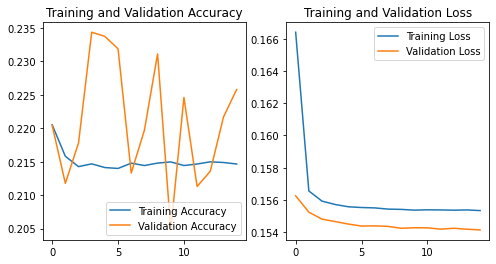

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('saved_model_wikimedia')

In [32]:
vg = datagen.flow_from_dataframe(
        dataframe=training_set, 
        subset='validation',
        classes=topics,
        color_mode='rgb',
        x_col='full_path', 
        y_col='labels', 
        class_mode='categorical', 
        target_size=target_size,
        shuffle=False
        )

/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 41468 invalid image filename(s) in x_col="full_path". These filename(s) will be ignored.
  warnings.warn(


Found 19375 validated image filenames belonging to 41 classes.


In [33]:
val_predictions = model.predict(vg)
val_predictions

array([[-1.6884366 , -4.016664  , -6.7662334 , ..., -1.0056901 ,
        -3.9483628 , -4.113852  ],
       [-1.3539528 , -3.8445323 , -6.3941107 , ..., -1.3150485 ,
        -4.3505325 , -4.267475  ],
       [-1.7036175 , -3.9181514 , -6.2623363 , ..., -1.4409082 ,
        -5.2521706 , -3.9551737 ],
       ...,
       [-0.63245404, -3.899385  , -5.5006227 , ..., -1.2743526 ,
        -4.357171  , -3.7367036 ],
       [-1.7918313 , -4.49608   , -6.4092836 , ..., -1.4253566 ,
        -4.8286886 , -3.9631584 ],
       [-0.78355706, -3.8557003 , -5.6140833 , ..., -1.5392449 ,
        -4.8040066 , -3.9200006 ]], dtype=float32)

In [35]:
name_id_map = train_generator.class_indices
class_names = len(name_id_map)*[0]
for k in name_id_map.keys():
    class_names[name_id_map[k]] = k

In [38]:
from collections import Counter

total = Counter()
correct = Counter()
for i in range(len(vg.classes)):
    true_y = vg.classes[i]
    for l in true_y:
        total[l]+=1
    predicted_y = np.argwhere(val_predictions[i]>=0.2)
    for p in predicted_y:
        if p[0] in true_y:
            correct[p[0]]+=1

for k in sorted(total.keys()):
    print(class_names[k].split(".")[-1], "{}/{} == {}".format(correct[k], total[k], correct[k]/total[k]))

Biography* 55/5100 == 0.010784313725490196
Food and drink 0/381 == 0.0
Internet culture 0/55 == 0.0
Linguistics 0/73 == 0.0
Literature 0/457 == 0.0
Books 0/100 == 0.0
Entertainment 0/222 == 0.0
Films 0/227 == 0.0
Media* 0/1409 == 0.0
Music 0/621 == 0.0
Radio 0/43 == 0.0
Software 0/18 == 0.0
Television 0/218 == 0.0
Video games 0/38 == 0.0
Performing arts 0/185 == 0.0
Philosophy and religion 0/1145 == 0.0
Sports 0/1832 == 0.0
Architecture 0/2563 == 0.0
Comics and Anime 0/45 == 0.0
Fashion 0/111 == 0.0
Visual arts* 0/3355 == 0.0
Geographical 0/2274 == 0.0
Business and economics 0/783 == 0.0
Education 0/525 == 0.0
History 0/1411 == 0.0
Military and warfare 0/1784 == 0.0
Politics and government 2/1867 == 0.0010712372790573112
Society 0/844 == 0.0
Transportation 4/2169 == 0.0018441678192715537
Biology 1/2026 == 0.0004935834155972359
Chemistry 0/71 == 0.0
Computing 0/69 == 0.0
Earth and environment 0/453 == 0.0
Engineering 0/947 == 0.0
Libraries & Information 0/67 == 0.0
Mathematics 0/9 == 0.

In [37]:
name_id_map

{'Culture.Biography.Biography*': 0,
 'Culture.Food and drink': 1,
 'Culture.Internet culture': 2,
 'Culture.Linguistics': 3,
 'Culture.Literature': 4,
 'Culture.Media.Books': 5,
 'Culture.Media.Entertainment': 6,
 'Culture.Media.Films': 7,
 'Culture.Media.Media*': 8,
 'Culture.Media.Music': 9,
 'Culture.Media.Radio': 10,
 'Culture.Media.Software': 11,
 'Culture.Media.Television': 12,
 'Culture.Media.Video games': 13,
 'Culture.Performing arts': 14,
 'Culture.Philosophy and religion': 15,
 'Culture.Sports': 16,
 'Culture.Visual arts.Architecture': 17,
 'Culture.Visual arts.Comics and Anime': 18,
 'Culture.Visual arts.Fashion': 19,
 'Culture.Visual arts.Visual arts*': 20,
 'Geography.Geographical': 21,
 'History and Society.Business and economics': 22,
 'History and Society.Education': 23,
 'History and Society.History': 24,
 'History and Society.Military and warfare': 25,
 'History and Society.Politics and government': 26,
 'History and Society.Society': 27,
 'History and Society.Transp